In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing, tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
%matplotlib inline


In [2]:
# load the dataset
df = pd.read_csv("project/resources/Hotels_data_Changed.csv")
# validates that there are no null values in the dataset
if df.isnull().values.any():
    print("NOTICED: there are some values that are 'NaN' in the dataset")


In [3]:
def drop_outliers(df, field_name):
    print("Removing data outliers by column name:", field_name)
    distance = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df.drop(df[df[field_name] > distance + np.percentile(df[field_name], 75)].index, inplace=True)
    df.drop(df[df[field_name] < np.percentile(df[field_name], 25) - distance].index, inplace=True)


len_before = len(df)
field = 'DiscountPerc'
drop_outliers(df, field)
print("Number of rows after removing outliers: {}, down by {}%".format(len(df),
                                                                       round((len_before - len(df)) / len_before * 100),
                                                                       2))


Removing data outliers by column name: DiscountPerc
Number of rows after removing outliers: 177121, down by 6%


In [4]:
used_features = [
    "WeekDay",
    "Snapshot Date",
    "Checkin Date",
    "DayDiff",
    "Hotel Name"
]
len_before = len(df)
idx = df.groupby(used_features, sort=False)['DiscountPerc'].transform(max) == df['DiscountPerc']
df = df[idx]
print("Number of rows after GroupBy the data to take maximum discount price: {}, down by {}%".format(len(df),
                                                                                                     round((
                                                                                                                       len_before - len(
                                                                                                                   df)) / len_before * 100),
                                                                                                     2))


Number of rows after GroupBy the data to take maximum discount price: 113144, down by 36%


In [5]:
# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
# integer encode
le = preprocessing.LabelEncoder()

# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
integer_encoded = df.apply(le.fit_transform)

# apply the values into the original data
for row in integer_encoded[used_features]:
    df[row] = integer_encoded[row]


In [6]:
# make sure 'Discount Code' type is int64
y = df["Discount Code"].astype(int)

# Split dataset in training and test datasets
X_train, X_test, y_train, y_test = train_test_split(df[used_features], y, test_size=0.3, random_state=int(time.time()))


In [7]:
# Instantiate the classifier
model = GaussianNB()


# Train classifier
model.fit(X_train, y_train)
# predict the class for the data instances.
y_pred = model.predict(X_test)


/Users/barzrihan/.conda/envs/data_science_02/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


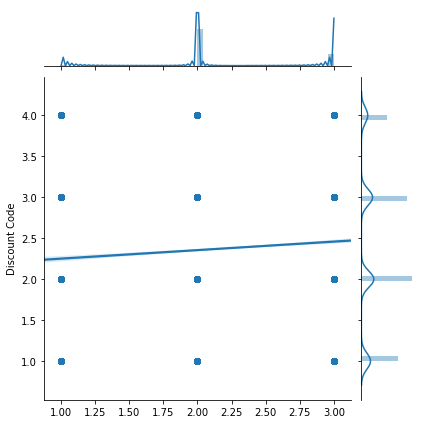

In [8]:
sns.jointplot(y_pred, y_test, kind="reg")


In [9]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.34      0.01      0.01      7906
           2       0.32      0.76      0.45     10792
           3       0.32      0.26      0.29      9711
           4       0.00      0.00      0.00      5535

   micro avg       0.32      0.32      0.32     33944
   macro avg       0.24      0.26      0.19     33944
weighted avg       0.27      0.32      0.23     33944



/Users/barzrihan/.conda/envs/data_science_02/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/barzrihan/.conda/envs/data_science_02/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/barzrihan/.conda/envs/data_science_02/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


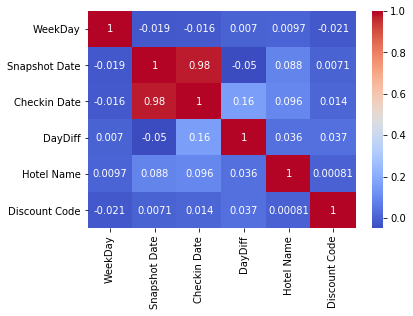

In [10]:
ax = sns.heatmap(df[used_features + ["Discount Code"]].corr(), cmap='coolwarm', annot=True)


In [11]:
# Instantiate the classifier
model = tree.DecisionTreeClassifier()

# Train classifier
model.fit(X_train, y_train)
model.feature_importances_

# predict the class for the data instances.
y_pred = model.predict(X_test)


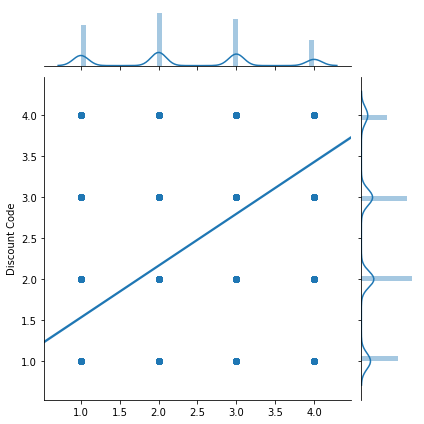

In [13]:
sns.jointplot(y_pred, y_test, kind="reg")


In [14]:
print(classification_report(y_test, y_pred))  


              precision    recall  f1-score   support

           1       0.67      0.71      0.69      7906
           2       0.72      0.73      0.72     10792
           3       0.74      0.72      0.73      9711
           4       0.72      0.67      0.69      5535

   micro avg       0.71      0.71      0.71     33944
   macro avg       0.71      0.71      0.71     33944
weighted avg       0.71      0.71      0.71     33944



In [1]:
# cross validation


In [ ]:
# הסבירו מהם הפרמטרים שהשפיעו הכי הרבה על ההחלטה ונסו לכמת עד כמה כל פרמטר משפיע


In [ ]:
# הראו באמצעות מדדים סטטיסטיים את איכות התוצאות (ROC, FP, FN)
# predict probabilities
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(testy, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(testy, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()